In [47]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict

In [37]:
##########################################################################
# Important Note: This notebook only uses one csv file to test the model #
##########################################################################

In [38]:
# Assign processed data to data_files
cwd = os.getcwd()
data_dir = os.path.join(cwd, "Data/")
data_files = [f for f in os.listdir(str(data_dir)) if f.endswith('csv')]

data_train_name = [f for f in data_files if 'TRAIN' in f]
data_test_name = [f for f in data_files if 'TEST' in f]

data_train = pd.read_csv(os.path.join(data_dir,data_train_name[0]))
data_test = pd.read_csv(os.path.join(data_dir,data_test_name[0]))


In [39]:
# Drop columns needed for classification group
boolean_col = ['highavse','lowavse','truedcr','lq']
data_train_filtered = data_train.drop(columns=boolean_col+['id'])
data_test_filtered = data_test.drop(columns=boolean_col+['id'])

# Find and Drop rows with missing values
data_train_filtered = data_train_filtered.dropna()
data_test_filtered = data_test_filtered.dropna()

# Drop irrelevant features and feature with perfect multicollinearity 
data_train_filtered = data_train_filtered.drop(columns=['tdrift50','tdrift10'])
data_test_filtered = data_test_filtered.drop(columns=['tdrift50','tdrift10'])

In [ ]:
# Train Test split
X_train = data_train_filtered.drop(columns=['energylabel'])
X_test = data_test_filtered.drop(columns=['energylabel'])
y_train = data_train_filtered['energylabel']
y_test = data_test_filtered['energylabel']

# Standardizing our columns
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Perform 5-fold cross-validation
linear_reg = LinearRegression()
cv_scores = cross_val_score(linear_reg, X_train_standardized, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive MSE
cv_scores = -cv_scores

# Train the Linear Regression Model
linear_reg = LinearRegression()
linear_reg.fit(X_train_standardized,y_train)
y_pred = linear_reg.predict(X_test_standardized)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2= r2_score(y_test, y_pred)

In [43]:
mse,r2

(4706.421983595325, 0.9894859088263802)

In [44]:
print(np.mean(abs(y_pred - y_test)))

16.143720393195345


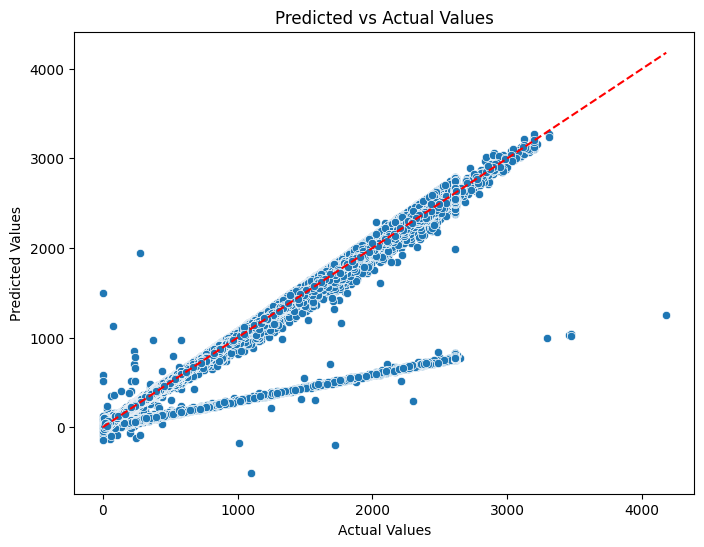

In [45]:
# Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

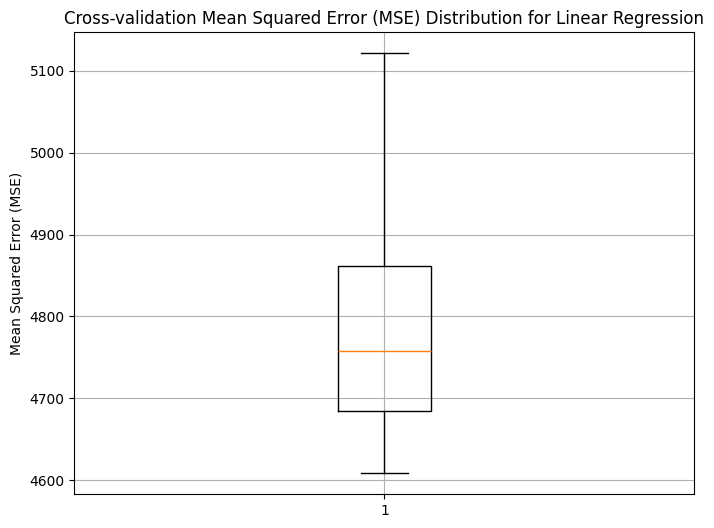

In [46]:
# Plot the cross-validation MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(cv_scores)
plt.title("Cross-validation Mean Squared Error (MSE) Distribution for Linear Regression")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()

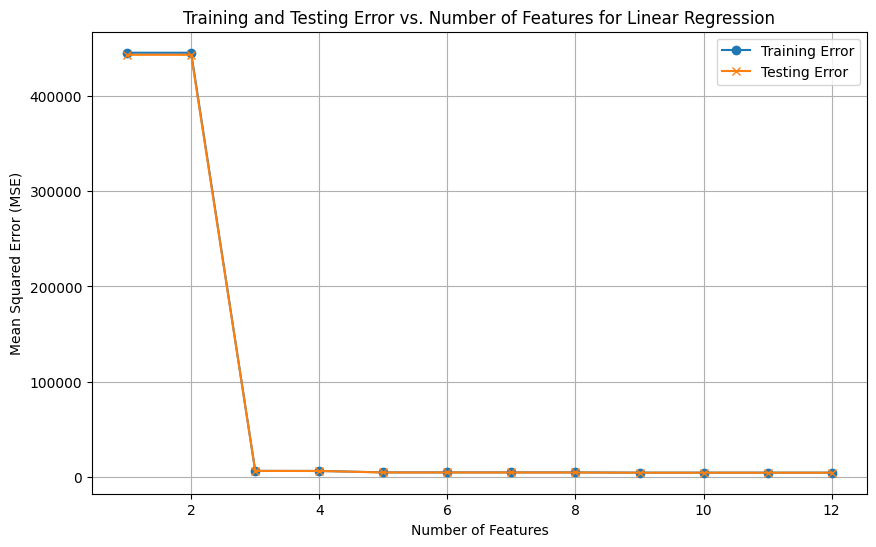

In [56]:
# Initialize the Linear Regression model
linear_reg = LinearRegression()

# Number of features in the dataset
n_features = X_train_standardized.shape[1]

# Arrays to store errors
train_errors = []
test_errors = []

# Iterate over number of features from 1 to n_features
for i in range(1, n_features + 1):
    # Select the first 'i' features
    X_train_subset = X_train_standardized[:, :i]
    X_test_subset = X_test_standardized[:, :i]
    
    # Train the model
    linear_reg.fit(X_train_subset, y_train)
    
    # Make predictions
    train_preds = linear_reg.predict(X_train_subset)
    test_preds = linear_reg.predict(X_test_subset)
    
    # Calculate errors (Mean Squared Error)
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    
    # Append the errors to the lists
    train_errors.append(train_mse)
    test_errors.append(test_mse)

# Plot the training and testing errors as the number of features increases
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_features + 1), train_errors, label="Training Error", marker='o')
plt.plot(range(1, n_features + 1), test_errors, label="Testing Error", marker='x')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Testing Error vs. Number of Features for Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Find and print the minimum errors and corresponding number of features
min_train_error = min(train_errors)
min_test_error = min(test_errors)

# Find the index of the minimum error, which corresponds to the number of features
min_train_error_index = train_errors.index(min_train_error) + 1
min_test_error_index = test_errors.index(min_test_error) + 1

print(f"Minimum Training Error: {min_train_error} with {min_train_error_index} features")
print(f"Minimum Testing Error: {min_test_error} with {min_test_error_index} features")

Minimum Training Error: 4801.6938927571655 with 12 features
Minimum Testing Error: 4706.421983595325 with 12 features


Here we can see that our MSE is at it's lowest the more features we use, so for our models we plan to use all 12 of our extracted parameters to train. In order to reduce over fitting, we performed cross validation to ensure that the model can be generalized to an independent data set.